In [ ]:
# Chase Abram
# IO 2 2021 with Hortacsu

In [2]:
using CSV
using DataFrames
using ForwardDiff
using LinearAlgebra
using Optim

using Random, Distributions
using Statistics
# using Pkg
# Pkg.add("StatsPlots")
using StatsPlots

using Plots

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278
┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278
┌ Info: Precompiling ForwardDiff [f6369f11-7733-5829-9624-2563aa707210]
└ @ Base loading.jl:1278
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1278
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1278
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278


In [5]:
# Section 1.3

# Compute the implied best-response probabilities
function BR_p(p, x, alpha, delta, sym = false)
    
    return exp.(alpha .* x .- delta .* reverse(p) .- maximum(p))./(exp(-maximum(p)) .+ exp.(alpha .*x .- delta .* reverse(p) .- maximum(p)))
    
#     if sym
#         return (exp.(alpha*x .- delta .* reverse(p) .- maximum(p))./(exp(-maximum(p)) .+ exp.(alpha*x .- delta .* reverse(p) .- maximum(p))))[1]
#     else
#         return exp.(alpha*x .- delta .* reverse(p) .- maximum(p))./(exp(-maximum(p)) .+ exp.(alpha*x .- delta .* reverse(p) .- maximum(p)))
#     end
end

# Finds fixed point
function fp_logit_contract(x, alpha, delta, sym = false, maxiter = 1000, tol = 1e-4)
    
    # Impose symmetry
    if sym
        p = [1/2]
        pnew = [0]
    # Or not
    else
        p = 1/2 .* ones(2)
        pnew = zeros(2)
    end
    
    # Fix parameters
    f(z) = BR_p(z,x,alpha,delta)
    
    # Initialize
    it = 0
    diff = Inf
    
    # Find fixed point via contraction
    while it < maxiter && diff > tol
        pnew = f(p)
        diff = abs(maximum(pnew - p))
        it += 1
        p = pnew
    end
    
#     println("Exited Contract")
#     println("it: ", it, ", diff: ", diff)
    
    if sym
        return p[1]
    end
    
    return p
end

# Finds local FP by Newton-Kantorovich
function fp_logit_nk(x, alpha, delta, sym = false, p_init = [0.5], maxiter = 1000, tol = 1e-14)
    
    # Fix parameters
    f(z) = BR_p(z,x,alpha,delta) - z
    
    # Initialize
    it = 0
    diff = Inf
    
    p = p_init
    
    # Find fixed point
    while it < maxiter && diff > tol
#         println("AD: ", ForwardDiff.jacobian(f, p))
        pnew = p - ForwardDiff.jacobian(f, p) \ (f(p))
        diff = abs(maximum(pnew - p))
        it += 1
        p = pnew
    end
    
#     println("Exited NK") 
#     println("it: ", it, ", diff: ", diff)
#     println("p: ", p)
    
#     if isnan(p[1])
#         p = p_init
        
#         it = 0
#         diff = Inf
        
#         # Find fixed point
#         while it < maxiter && diff > tol
#             println("AD: ", ForwardDiff.jacobian(f, p))
#             pnew = p - ForwardDiff.jacobian(f, p) \ (f(p))
#             diff = abs(maximum(pnew - p))
#             it += 1
#             p = pnew
#         end
#     end
    
    # If symmetric, just return value
    if sym
        return p[1]
    else
        return p
    end
    
end

# Find all the fixed points
function all_fp_logit_nk(x, theta::AbstractVector{T}, grid_size = 10, maxiter = 1000, tol = 1e-14) where T
    
    grid = LinRange(0,1,grid_size)
    
    fps = []
    
    # Try different starting points
    for i in grid
        for j in grid
#             println("i: ", i, ", j: ", j)
#             println([i, j])
            add_f = fp_logit_nk(x, theta[1], theta[2], false, [i, j], maxiter, tol)
#             println("add_f: ", add_f)
            
            # Check if (rough) duplicate
            add = true
            for f in fps
                if maximum(abs.(f - add_f)) < tol*1e2 || isnan(add_f[1]) || isnan(add_f[2])
                    add = false
                end
            end
            
            if add
#                 println("i: ", i, ", j: ", j, ", add_f: ", add_f)
                push!(fps, add_f)
            end
        end
    end
    
    fps = unique(fps)
    
    sort!(fps, rev = true)
    fps_mat = zeros(T, length(fps), 2)
    for i in 1:size(fps_mat,1)
        fps_mat[i,:] = fps[i]
    end
    
    return fps_mat
end



all_fp_logit_nk (generic function with 4 methods)

In [4]:
# alpha = [1, 3]
# delta = [1, 6]
# x = [1, 2]
# p_init = 1/2 .* ones(2)
# p_init = [1/2]

# logit_p(p_init, x, alpha, delta)

# fp_logit(x, alpha, delta)
# println("Pure Contract")
# for i in 1:2
#     for j in 1:2
#         println("BNE (sym): alpha = ", alpha[i], ", delta = ", delta[i], ", x = ", x[j])
#         println("P_i = ", fp_logit_contract(x[j], alpha[i], delta[i], true))
#     end
# end
# println()
# for i in 1:2
#     for j in 1:2
#         println("BNE: alpha = ", alpha[i], ", delta = ", delta[i], ", x = ", x[j])
#         println("P_i = ", fp_logit_contract(x[j], alpha[i], delta[i]))
#     end
# end

# println("Pure NK")
# for i in 1:2
#     for j in 1:2
#         println("BNE (sym): alpha = ", alpha[i], ", delta = ", delta[i], ", x = ", x[j])
#         println("P_i = ", fp_logit_nk(x[j], alpha[i], delta[i], p_init))
#     end
# end


# for i in 1:2
#     for j in 1:2
#         println("BNE: alpha = ", alpha[i], ", delta = ", delta[i], ", x = ", x[j])
#         println("P_i = ", fp_logit_contract(x[j], alpha[i], delta[i]))
#     end
# end

# p_init = [0.8, 0.9]
# fp_logit_nk(1, 3, 6, true, [0.9])

# inds_test = [1,2,2,1,2,2,2,2]
cat(all_fp_logit_nk(1, [3.0, 6.0]), all_fp_logit_nk(2, [3.0, 6.0]), dims=3)


LoadError: UndefVarError: all_fp_logit_nk not defined

In [1087]:
# Parameters
alpha = 3
delta = 6
T = 1000
S = 1

# Generate data
Random.seed!(1234)
# Errors
F = Logistic()
ep = rand(F, S, T, 2)
# Covariates
x = (rand(S, T) .> 1/2) .+ 1

# Initialize BR probs
p = zeros(S,T)
# p = Array{Array{Float64}}(undef, S, T)
for s in 1:S
    for t in 1:T
        p[s,t] = fp_logit_nk(x[s,t], alpha, delta, true)
    end
end
# Find implied entry decisions
y = zeros(S,T,2)
y = (alpha .* x .- delta.*p .+ ep) .> 0


fp_logit_nk.(x, 3, 6, true)

# Log-likelihood
function siam_log_lik(theta, x, y)
    return sum(y .* log.(fp_logit_nk.(x, theta[1], theta[2], true)) .+ (1 .- y) .* log.(1 .- fp_logit_nk.(x, theta[1], theta[2], true)))
end


# Run Monte-Carlo with symmetric eq. ass.
function sym_MC(alpha, delta, S, T, seed)
    
    # Set seed (for replicability)
    Random.seed!(seed)
    
    # Errors
    F = Logistic()
    ep = rand(F, S, T, 2)
    
    # Covariates
    x = (rand(S, T) .> 1/2) .+ 1
    
    # Probabilities
    p = zeros(S,T)
    for s in 1:S
        for t in 1:T
            p[s,t] = fp_logit_nk(x[s,t], alpha, delta, true)
        end
    end
    
    # Implied entries
    y = zeros(S,T,2)
    y = (alpha .* x .- delta.*p .+ ep) .> 0
    
    # Initialize
    pars = zeros(S,2)
    
    # Get implied parameter estimates for each simulation
    for s in 1:S
        # Create function of parameters only
        sll(t) = -siam_log_lik(t, x[s,:], y[s,:,:])
        
        # Max log-lik
        pars[s,:] = optimize(sll, [1.0,1.0], BFGS(), Optim.Options(show_trace = true); autodiff = :forward).minimizer
        
        # Status updates
        println("Simulation ", s, " complete:")
        println("    par: ", pars[s,:])
    end
    
    return pars
end

# alpha = 3, delta = 6, S = 50, T = 1000, seed = 1234
sim_pars = sym_MC(3, 6, 50, 1000, 1234)

Iter     Function value   Gradient norm 
     0     1.220027e+03     3.303239e+01
 * time: 0.0008699893951416016
     1     1.218948e+03     1.429400e+01
 * time: 2.977509021759033
     2     1.215338e+03     2.411327e+01
 * time: 5.223007917404175
     3     1.210173e+03     1.223891e+00
 * time: 7.971118927001953
     4     1.209725e+03     7.546933e+00
 * time: 9.917665958404541
     5     1.209408e+03     1.230647e+01
 * time: 12.339224100112915
     6     1.209128e+03     4.707503e+00
 * time: 14.806117057800293
     7     1.209085e+03     1.187031e-01
 * time: 16.814122915267944
     8     1.209085e+03     1.666364e-02
 * time: 19.80164909362793
     9     1.209085e+03     1.780696e-05
 * time: 22.4620680809021
    10     1.209085e+03     5.654814e-09
 * time: 24.06056499481201
Simulation 1 complete:
    par: [2.2499023672422975, 4.04968873822775]
Iter     Function value   Gradient norm 
     0     1.209323e+03     2.328724e+01
 * time: 0.0003039836883544922
     1     1.208610e+

     0     1.272713e+03     1.214460e+02
 * time: 0.0002589225769042969
     1     1.260550e+03     2.201802e+01
 * time: 4.747514009475708
     2     1.245387e+03     4.178881e+01
 * time: 6.6363677978515625
     3     1.234254e+03     1.310508e+01
 * time: 10.23860478401184
     4     1.233268e+03     2.003251e+00
 * time: 12.104352951049805
     5     1.233237e+03     4.295696e-01
 * time: 13.955406904220581
     6     1.233224e+03     5.779199e-01
 * time: 17.803013801574707
     7     1.233222e+03     1.462893e-03
 * time: 20.40872287750244
     8     1.233222e+03     1.431441e-04
 * time: 22.12158179283142
     9     1.233222e+03     1.469691e-09
 * time: 23.825856924057007
Simulation 10 complete:
    par: [4.4096675453117795, 9.920425102569173]
Iter     Function value   Gradient norm 
     0     1.256012e+03     9.328166e+01
 * time: 0.00029015541076660156
     1     1.248696e+03     9.418717e+00
 * time: 2.2447619438171387
     2     1.240410e+03     3.983985e+01
 * time: 3.984

     7     1.230154e+03     2.762993e-01
 * time: 12.279820919036865
     8     1.230154e+03     7.794347e-03
 * time: 13.686846017837524
     9     1.230154e+03     3.100625e-05
 * time: 15.893939971923828
    10     1.230154e+03     2.418041e-09
 * time: 17.290380001068115
Simulation 19 complete:
    par: [2.050626608050219, 3.7448597225269755]
Iter     Function value   Gradient norm 
     0     1.224792e+03     4.414277e+01
 * time: 0.00028514862060546875
     1     1.223128e+03     2.688680e+01
 * time: 1.6654870510101318
     2     1.213965e+03     2.443398e+01
 * time: 3.392803192138672
     3     1.208747e+03     5.138366e+00
 * time: 6.605317115783691
     4     1.208577e+03     1.121172e+01
 * time: 8.847522020339966
     5     1.207912e+03     6.283536e+00
 * time: 11.085799217224121
     6     1.207819e+03     3.241923e-01
 * time: 12.654913187026978
     7     1.207819e+03     8.002639e-02
 * time: 14.339129209518433
     8     1.207819e+03     2.849595e-04
 * time: 15.8989

Simulation 28 complete:
    par: [3.2749846696531493, 6.471675878311268]
Iter     Function value   Gradient norm 
     0     1.215237e+03     3.063741e+01
 * time: 0.00028896331787109375
     1     1.214145e+03     2.039643e+01
 * time: 1.6080920696258545
     2     1.202699e+03     2.580179e+01
 * time: 3.3047640323638916
     3     1.197033e+03     1.089172e+00
 * time: 7.056596994400024
     4     1.196725e+03     5.902000e+00
 * time: 8.722749948501587
     5     1.196389e+03     1.124447e+01
 * time: 10.98030400276184
     6     1.195960e+03     7.329602e+00
 * time: 13.05617904663086
     7     1.195825e+03     2.060411e-02
 * time: 14.639940023422241
     8     1.195825e+03     1.862951e-02
 * time: 16.35377597808838
     9     1.195825e+03     6.658526e-07
 * time: 18.65777897834778
    10     1.195825e+03     2.118053e-09
 * time: 21.061909914016724
Simulation 29 complete:
    par: [3.1639767704208897, 6.186471201515088]
Iter     Function value   Gradient norm 
     0     1.20

     3     1.213443e+03     5.834410e+00
 * time: 7.017261028289795
     4     1.213229e+03     1.221143e+01
 * time: 8.54953908920288
     5     1.212657e+03     8.574819e+00
 * time: 10.890322923660278
     6     1.212508e+03     5.135847e-01
 * time: 12.42770791053772
     7     1.212506e+03     1.135554e-01
 * time: 13.996778964996338
     8     1.212506e+03     5.929935e-04
 * time: 15.574599027633667
     9     1.212506e+03     1.489958e-06
 * time: 17.89856791496277
    10     1.212506e+03     6.407319e-12
 * time: 19.60392713546753
Simulation 38 complete:
    par: [2.497719776278499, 4.6584560285252445]
Iter     Function value   Gradient norm 
     0     1.246377e+03     9.375826e+01
 * time: 0.0002849102020263672
     1     1.238819e+03     1.232948e+01
 * time: 2.1512320041656494
     2     1.219151e+03     3.865838e+01
 * time: 3.6975550651550293
     3     1.209858e+03     1.299587e+01
 * time: 7.142915964126587
     4     1.208869e+03     1.528682e+00
 * time: 8.8757140636

     6     1.220161e+03     5.833270e-01
 * time: 11.76792597770691
     7     1.220158e+03     1.489762e-01
 * time: 13.268306016921997
     8     1.220158e+03     1.078112e-03
 * time: 14.78826379776001
     9     1.220158e+03     3.936941e-06
 * time: 17.183960914611816
    10     1.220158e+03     3.823342e-11
 * time: 18.68444299697876
Simulation 47 complete:
    par: [2.6943369071378602, 5.2277181654825045]
Iter     Function value   Gradient norm 
     0     1.249483e+03     7.905540e+01
 * time: 0.0003070831298828125
     1     1.244059e+03     9.509385e+00
 * time: 2.1672351360321045
     2     1.237080e+03     3.744874e+01
 * time: 3.830881118774414
     3     1.228868e+03     5.832928e-01
 * time: 6.318488121032715
     4     1.228737e+03     4.886399e+00
 * time: 7.8420209884643555
     5     1.228457e+03     5.915801e+00
 * time: 10.796516180038452
     6     1.228370e+03     5.219772e-01
 * time: 12.169523000717163
     7     1.228368e+03     6.203725e-02
 * time: 13.521118

50×2 Array{Float64,2}:
 2.2499    4.04969
 3.14075   6.06274
 3.55177   7.41068
 4.07023   8.46127
 2.79097   5.39623
 2.87553   5.6721
 1.95264   3.50159
 2.30945   4.6527
 4.12704   8.49065
 4.40967   9.92043
 3.07039   6.39017
 3.10613   6.50466
 3.65533   7.44141
 ⋮        
 5.06723  11.3559
 2.86626   5.56755
 2.79181   5.40313
 3.22535   6.73554
 3.25778   6.30182
 2.91313   5.82625
 2.64255   5.15766
 2.31722   4.32425
 2.69434   5.22772
 2.82436   5.68686
 3.17951   6.5261
 2.62067   5.37176

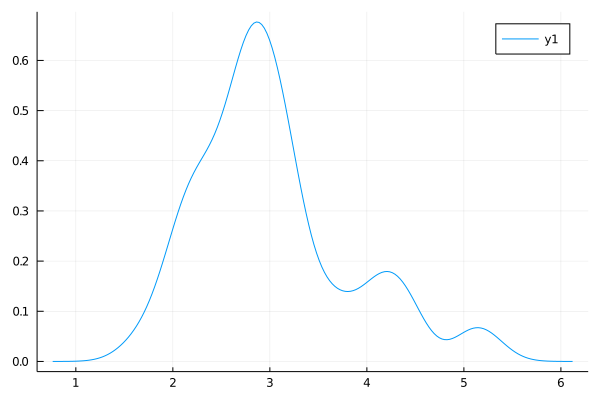

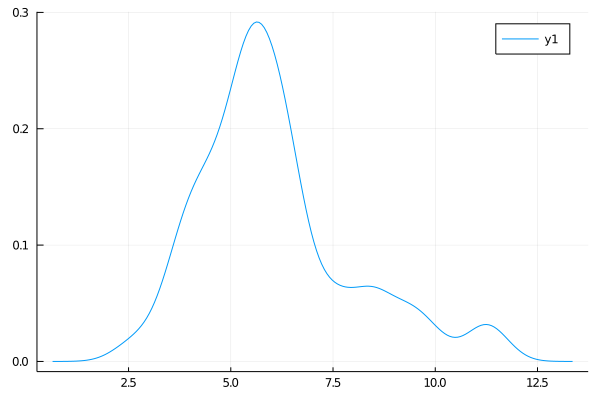

alpha: mean = 3.0208624133585658 var = 0.6222685026126851
delta: mean = 6.069350150911969 var = 3.620661536527681


In [1088]:
# Plots of empirical density for each parameter
d_alpha = density(sim_pars[:,1])
display(d_alpha)
d_delta = density(sim_pars[:,2])
display(d_delta)
println("alpha: mean = ", mean(sim_pars[:,1]), " var = ", var(sim_pars[:,1]))
println("delta: mean = ", mean(sim_pars[:,2]), " var = ", var(sim_pars[:,2]))

In [34]:
# Simulate data for Q4

function eq_probs(K)
    return exp.(LinRange(1,K,K)./2)./ sum(exp.(LinRange(1,K,K)./2))
end

function mll_term(x, y, ep, bnp)
    
    if (ep[x]' * (bnp[x][:,1].^y[1].*(1 .- bnp[x][:,1]).^(1 .- y[1]).*bnp[x][:,2].^y[2].*(1 .- bnp[x][:,2]).^(1 .- y[2])))[1] < 0
        println("neg in mll_term")
        println("    x: ", x)
        println("    y: ", y)
        println("    ep[x]: ", ep[x])
        println("    bnp[x]: ", bnp[x])
        return -Inf
    end
    
    return log.(ep[x]' * (bnp[x][:,1].^y[1].*(1 .- bnp[x][:,1]).^(1 .- y[1]).*bnp[x][:,2].^y[2].*(1 .- bnp[x][:,2]).^(1 .- y[2])))
end


# Log-likelihood (Gotta simplify this)
function mix_log_lik(theta::AbstractVector{T}, x, y) where T
    
    # Build bn_probs for each x
    bnp = [all_fp_logit_nk(1, theta), all_fp_logit_nk(2, theta)]
#     println("bnp top: ", bnp)
    for i in 1:length(bnp)
        if minimum(bnp[i]) < 0
            println("neg bnp: ", bnp)
            println("    at theta: ", theta)
        end
    end
    
    ep = [eq_probs(size(bnp[1],1)), eq_probs(size(bnp[2],1))]
    for i in 1:length(ep)
        if minimum(ep[i]) < 0
            println("neg ep: ", ep)
            println("    at theta: ", theta)
        end
    end
    
#     println("ep top: ", ep)
    
#     println("mll_term all (with test ep and bnp): ", sum([mll_term(x[i], y[i,:], ep, bnp) for i in 1:length(x)]))
    
    return sum([mll_term(x[i], y[i,:], ep, bnp) for i in 1:length(x)])
    
#     println("theta: ", theta)
#     return 0
#     bn_probs (eq, firm, x)
#     bn_probs = zeros(T,3,2,2) #.+ (theta[1]./(theta[1] + theta[2])).^2
#     bn_probs .= all_fp_logit_nk(2, theta)
#     bn_probs = cat(all_fp_logit_nk(1, theta), all_fp_logit_nk(2, theta), dims=3)
    
#     println("bn1: ", all_fp_logit_nk(1, theta))
#     println("bn1: ", all_fp_logit_nk(1, theta)[2])
#     println("bn1: ", all_fp_logit_nk(1, theta)[2,2])
#     bn_probs[:,:,1] .= all_fp_logit_nk(1, theta)
    
#     println("bn2: ", all_fp_logit_nk(2, theta))
#     bn_probs[:,:,2] .= all_fp_logit_nk(2, theta)
#     for k in 1:3
#         for j in 1:2
#             println("in mll (full): ", all_fp_logit_nk(j, theta))
#             println("in mll: ", all_fp_logit_nk(j, theta)[k,:])
# #             bn_probs[k,:,j] = all_fp_logit_nk(j, theta)[k]
#             bn_probs[k,:,j] = [0.1, 0.9]
# #             bn_probs[k,:,j] = theta
#         end
#     end
    
#     bn_probs = afln(theta)
#     println("size(bn_probs): ", size(bn_probs))
#     println("bn_probs: ", bn_probs)
    
#     println(log.(eq_probs*bn_probs[x,1]))
#     return sum(log.(eq_probs .* bn_probs[:,1,x].^y[:,1].*(1 .-bn_probs[:,1,x]).^(1 .-y[:,1]).*bn_probs[:,2,x].^y[:,2].*(1 .-bn_probs[:,2,x]).^(1 .-y[:,2])))
    
#     return sum(log.(eq_probs[1].*bn_probs[1,1,x].^y[:,1].*(1 .-bn_probs[1,1,x]).^(1 .-y[:,1]).*bn_probs[1,2,x].^y[:,2].*(1 .-bn_probs[1,2,x]).^(1 .-y[:,2]) .+
#     eq_probs[2].*bn_probs[2,1,x].^y[:,1].*(1 .-bn_probs[2,1,x]).^(1 .-y[:,1]).*bn_probs[2,2,x].^y[:,2].*(1 .-bn_probs[2,2,x]).^(1 .-y[:,2]) .+
#     eq_probs[3].*bn_probs[3,1,x].^y[:,1].*(1 .-bn_probs[3,1,x]).^(1 .-y[:,1]).*bn_probs[3,2,x].^y[:,2].*(1 .-bn_probs[3,2,x]).^(1 .-y[:,2])))
    
#     return sum(y .* log.(fp_logit_nk.(x, theta[1], theta[2], true)) .+ (1 .- y) .* log.(1 .- fp_logit_nk.(x, theta[1], theta[2], true)))
end



# Run Monte-Carlo with possible asymmetry per Q4
function asym_MC(theta, S, T, seed)
    
    # Set seed (for replicability)
    Random.seed!(seed)
    
    # Errors
    F = Logistic()
    ep = rand(F, S, T, 2)
    
    # Covariates
    x = (rand(S, T) .> 1/2) .+ 1
    
    # Store eqs. for each x type
    eqs = zeros(3,2,2)
    eqs[:,:,1] = all_fp_logit_nk(1, theta)
    eqs[:,:,2] = all_fp_logit_nk(2, theta)
    
    # Number of eqs (use that 3 in both cases)
    K = size(eqs,1)
    println("K: ", K)
    
    # Generate cutoff for choosing eq type
    eq_probs = LinRange(1,K,K)
    eq_probs = exp.(eq_probs./2)
    eq_probs = eq_probs./ sum(eq_probs)
    println("eq_probs: ", eq_probs)
    eq_cuts = cumsum(eq_probs)
#     sort!(eq_cuts)
    println("eq_cuts: ", eq_cuts)
    
    # Initialize
    eq_draw = 0
    eq = 0
    
    # Probabilities
    p = zeros(S,T,2)
    for s in 1:S
        for t in 1:T
            # Draw to choose eq
            eq_draw = rand()
            
            # Default to 1
            eq = K
            
            # Find where draw lies
            for k in 1:K-1
                if eq_cuts[k] < eq_draw && eq_draw < eq_cuts[k+1]
                    eq = k
                end
            end
            
            p[s,t,:] = eqs[eq,:,x[s,t]]
        end
    end
    
#     # Implied entries
    y = zeros(S,T,2)
    y = (theta[1] .* x .- theta[2].*p .+ ep) .> 0
    
#     println("mll test: ", mix_log_lik([3.0,6.0], x[1,:], y[1,:,:]))
    
    # Initialize
    pars = zeros(S,2)
    
    
    # Get implied parameter estimates for each simulation
    for s in 1:S
        # Create function of parameters only
#         sll(t) = -siam_log_lik(t, x[s,:], y[s,:,:])
        mll(t) = -mix_log_lik(t, x[s,:], y[s,:,:])
        
        # Max log-lik
        pars[s,:] = optimize(mll, [1.0,1.0], BFGS(), Optim.Options(show_trace = true); autodiff = :forward).minimizer
#         pars[s,:] = optimize(mll, [1.0,1.0], BFGS(), Optim.Options(show_trace = true)).minimizer
        
        # Status updates
        println("Simulation ", s, " complete:")
        println("    par: ", pars[s,:])
    end
    
    return pars
end

asim_pars = asym_MC([3.0, 6.0], 50, 1000, 123456)


K: 3
eq_probs: [0.1863237232258476, 0.30719588571849843, 0.506480391055654]
eq_cuts: [0.1863237232258476, 0.493519608944346, 1.0]
Iter     Function value   Gradient norm 
     0     1.240907e+03     7.124771e+01
 * time: 0.0003070831298828125
     1     1.238702e+03     4.881263e+01
 * time: 0.02000904083251953
     2     1.216417e+03     4.624353e+01
 * time: 0.11845803260803223
     3     1.191350e+03     3.648069e+01
 * time: 0.14250922203063965
     4     1.190873e+03     3.467009e+01
 * time: 0.6515882015228271
     5     1.188573e+03     2.601729e+00
 * time: 0.6823220252990723
     6     1.188493e+03     3.240080e-01
 * time: 0.7023301124572754
     7     1.188493e+03     1.000139e-03
 * time: 0.7803661823272705
     8     1.188493e+03     1.642210e-06
 * time: 0.8022580146789551
     9     1.188493e+03     3.034240e-12
 * time: 0.8177201747894287
Simulation 1 complete:
    par: [2.5517874309091098, 4.9864784923335135]
Iter     Function value   Gradient norm 
     0     1.249557

     2     1.225998e+03     1.801562e+01
 * time: 0.272442102432251
     3     1.187277e+03     5.801516e+01
 * time: 0.5090081691741943
     4     1.185861e+03     5.559154e+01
 * time: 0.568148136138916
     5     1.178827e+03     3.006160e+01
 * time: 0.660768985748291
     6     1.177149e+03     8.706003e+00
 * time: 0.6878540515899658
     7     1.176807e+03     7.963813e-01
 * time: 0.7229161262512207
     8     1.176805e+03     2.877914e-02
 * time: 0.8159141540527344
     9     1.176805e+03     1.873594e-04
 * time: 0.8514490127563477
    10     1.176805e+03     2.347366e-08
 * time: 0.8764050006866455
    11     1.176805e+03     3.244679e-13
 * time: 0.8995161056518555
Simulation 11 complete:
    par: [2.6087229443791546, 5.106642487258666]
Iter     Function value   Gradient norm 
     0     1.240892e+03     7.406223e+01
 * time: 8.606910705566406e-5
     1     1.236099e+03     1.021956e+01
 * time: 0.03868603706359863
     2     1.192951e+03     4.183735e+01
 * time: 0.103699

     1     1.222515e+03     4.364165e+01
 * time: 0.026478052139282227
     2     1.201432e+03     8.243725e+00
 * time: 0.21204400062561035
     3     1.188451e+03     5.040551e+01
 * time: 0.250338077545166
     4     1.173235e+03     4.923703e+00
 * time: 0.3339381217956543
     5     1.172744e+03     1.696866e+00
 * time: 0.35196995735168457
     6     1.172731e+03     8.446872e-01
 * time: 0.37111401557922363
     7     1.172730e+03     5.043108e-03
 * time: 0.4144141674041748
     8     1.172730e+03     1.273815e-05
 * time: 0.43639397621154785
     9     1.172730e+03     2.298851e-10
 * time: 0.4978330135345459
Simulation 21 complete:
    par: [2.5916907299386933, 4.9434054891709724]
Iter     Function value   Gradient norm 
     0     1.233114e+03     4.992670e+01
 * time: 0.0001461505889892578
     1     1.231204e+03     3.756150e+01
 * time: 0.02253103256225586
     2     1.185817e+03     5.964594e+00
 * time: 0.24521899223327637
     3     1.185668e+03     5.877745e+00
 * tim

     4     1.204585e+03     2.487597e+01
 * time: 0.24310708045959473
     5     1.202759e+03     1.915659e+00
 * time: 0.334683895111084
     6     1.202752e+03     4.991400e-02
 * time: 0.4560520648956299
     7     1.202752e+03     2.729322e-04
 * time: 0.524224042892456
     8     1.202752e+03     1.109614e-07
 * time: 0.6044290065765381
     9     1.202752e+03     1.176143e-13
 * time: 0.6375160217285156
Simulation 31 complete:
    par: [2.5018674877390805, 4.864351550771864]
Iter     Function value   Gradient norm 
     0     1.226035e+03     4.803225e+01
 * time: 7.200241088867188e-5
     1     1.224196e+03     3.386455e+01
 * time: 0.029986143112182617
     2     1.207661e+03     5.590531e+01
 * time: 0.21233820915222168
     3     1.184595e+03     1.617545e+01
 * time: 0.24449706077575684
     4     1.184110e+03     1.442651e+01
 * time: 0.266923189163208
     5     1.183681e+03     1.106945e+00
 * time: 0.30578112602233887
     6     1.183671e+03     9.540738e-03
 * time: 0.3

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    x: 2
    y: Bool[0, 1]
    ep[x]: [0.058012217397997876, 0.09564597678455913, 0.15769355638159327, 0.2599927206586828, 0.42865552877716695]
    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    x: 2
    y: Bool[0, 1]
    ep[x]: [0.058012217397997876, 0.09564597678455913, 0.15769355638159327, 0.2599927206586828, 0.42865552877716695]
    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    x: 2
    y: Bool[1, 0]
    ep[x]: [0.058012217397997876, 0.09564597678455913, 0.15769355638159327, 0.2599927206586828, 0.42865552877716695]
    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    ep[x]: [0.058012217397997876, 0.09564597678455913, 0.15769355638159327, 0.2599927206586828, 0.42865552877716695]
    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDif

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

    bnp[x]: ForwardDiff.Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64},Float64,2}[Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.5876462501618804,4093.8613229153116,-1770.6407588016364) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(2.587646250161881,4093.861322915308,-1770.6407588016352); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833127,0.019042999643261282,-0.008237201099746017) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.9999994497833098,0.019042999889734347,-0.008237201063138855); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044494,0.4301827149241562,-0.2015946432051007) Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8855013080044495,0.43018271488934656,-0.20159464319553821); Dual{ForwardDiff.Tag{var"#mll#129"{Array{Int64,2},Int64},Float64}}(0.8116203423879257,6.975891982820041,-3.046217701265603) Dual{For

     3     1.149616e+03     3.278691e+01
 * time: 1.1303560733795166
     4     1.149406e+03     3.214866e+01
 * time: 1.1519291400909424
     5     1.147482e+03     6.815976e+00
 * time: 1.1929490566253662
     6     1.147184e+03     1.292180e-01
 * time: 1.2216451168060303
     7     1.147184e+03     2.116271e-02
 * time: 1.2930679321289062
     8     1.147184e+03     4.737541e-06
 * time: 1.3191490173339844
     9     1.147184e+03     8.784065e-10
 * time: 1.3474059104919434
Simulation 37 complete:
    par: [2.7430491536174557, 5.230063655870107]
Iter     Function value   Gradient norm 
     0     1.264952e+03     1.024317e+02
 * time: 7.390975952148438e-5
     1     1.256428e+03     9.627322e+00
 * time: 0.035578012466430664
     2     1.232655e+03     3.562093e+01
 * time: 0.06702494621276855
     3     1.208728e+03     3.485235e+01
 * time: 0.15755987167358398
     4     1.207787e+03     2.551184e+01
 * time: 0.20840907096862793
     5     1.206353e+03     6.576485e+00
 * time: 0

     4     1.218009e+03     7.977747e+00
 * time: 0.27445316314697266
     5     1.189251e+03     5.937539e+00
 * time: 0.31337904930114746
     6     1.188694e+03     4.350896e+00
 * time: 0.3451120853424072
     7     1.188276e+03     4.991653e-01
 * time: 0.385699987411499
     8     1.188273e+03     9.046106e-02
 * time: 0.41228604316711426
     9     1.188273e+03     5.419992e-06
 * time: 0.4525871276855469
    10     1.188273e+03     3.885949e-08
 * time: 0.4738800525665283
    11     1.188273e+03     6.983303e-14
 * time: 0.5045170783996582
Simulation 47 complete:
    par: [2.5732001521121046, 5.065322993618948]
Iter     Function value   Gradient norm 
     0     1.248120e+03     7.174349e+01
 * time: 0.00010609626770019531
     1     1.246354e+03     5.500333e+01
 * time: 0.06082797050476074
     2     1.235854e+03     5.650041e+01
 * time: 0.09583806991577148
     3     1.230399e+03     1.351527e+01
 * time: 0.13389801979064941
     4     1.219236e+03     2.000161e+01
 * time:

50×2 Array{Float64,2}:
 2.55179  4.98648
 2.47395  4.87429
 2.44282  4.80141
 2.5242   4.83309
 2.52774  4.78561
 2.64061  5.16894
 2.52025  5.15478
 2.70424  5.11638
 2.50828  4.86693
 2.46267  4.9585
 2.60872  5.10664
 2.63861  5.22246
 2.67216  5.0246
 ⋮        
 2.3168   4.58524
 2.53733  4.82235
 2.58294  4.99379
 2.51693  5.00199
 2.78816  5.38481
 2.54874  4.85165
 2.48291  5.06445
 2.42722  4.59269
 2.5732   5.06532
 2.37584  4.54149
 2.4955   4.65721
 2.68405  5.19524

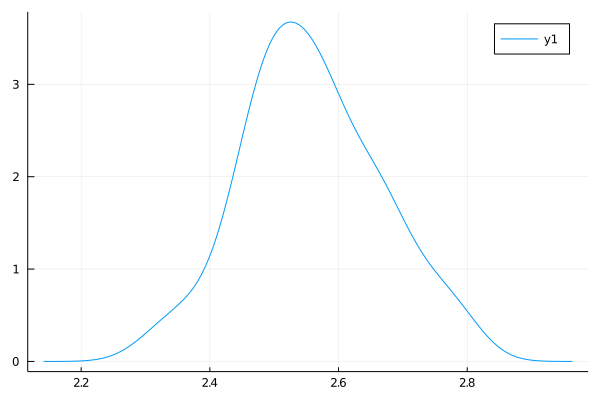

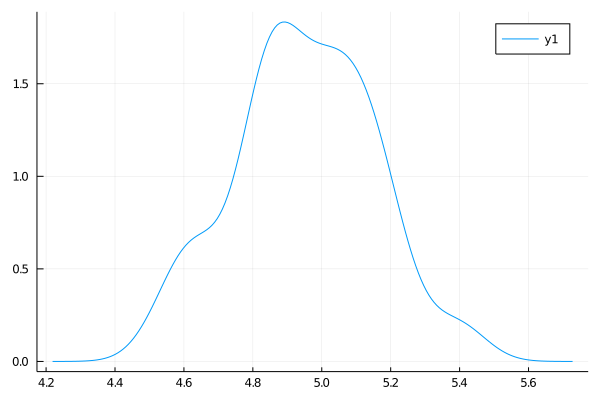

a_alpha: mean = 2.558530862755074 var = 0.011324646438661873
a_delta: mean = 4.950738347430385 var = 0.0396480678977324


In [35]:
# Plots of empirical density for each parameter
ad_alpha = density(asim_pars[:,1])
display(ad_alpha)
ad_delta = density(asim_pars[:,2])
display(ad_delta)
println("a_alpha: mean = ", mean(asim_pars[:,1]), " var = ", var(asim_pars[:,1]))
println("a_delta: mean = ", mean(asim_pars[:,2]), " var = ", var(asim_pars[:,2]))

In [916]:
# Simulate data for Q5

# Run Monte-Carlo with possible asymmetry per Q4
function uasym_MC(alpha, delta, S, T, seed)
    
    # Set seed (for replicability)
    Random.seed!(seed)
    
    # Errors
    F = Logistic()
    ep = rand(F, S, T, 2)
    
    # Covariates
    x = (rand(S, T) .> 1/2) .+ 1
    
    # Unobserved
    u = (rand(S, T) .< 1 ./(1 .+ x))
#     println("u: ", u)
    println("mean u: ", mean(u))
    
    # Store eqs. for each x type
    eqs = [all_fp_logit_nk(1, alpha, delta), all_fp_logit_nk(2, alpha, delta)]
    
    # Number of eqs (use that 3 in both cases)
    K = length(eqs[1])
    
    # Generate cutoff for choosing eq type
    eq_probs = [k for s in 1:S, t in 1:T, k in 1:K]
    eq_probs = exp.((eq_probs .+ u)./2)
    eq_probs = eq_probs./ sum(eq_probs, dims = 3)
    println("size(eq_probs): ", size(eq_probs))
#     println("eq_probs: ", eq_probs)
    eq_cuts = cumsum(eq_probs, dims = 3)
#     sort!(eq_cuts)
#     println("size(eq_cuts): ", size(eq_cuts))
#     println("eq_cuts: ", eq_cuts)
    
    # Initialize
    eq_draw = 0
    eq = 0
    
    # Probabilities
    p = zeros(S,T,2)
    for s in 1:S
        for t in 1:T
            # Draw to choose eq
            eq_draw = rand()
            
            # Default to 1
            eq = K
            
            # Find where draw lies
            for k in 1:K-1
                if eq_cuts[s,t,k] < eq_draw && eq_draw < eq_cuts[s,t,k+1]
                    eq = k
                end
            end
            
#             println("eqs[x[s,t]]: ", eqs[x[s,t]][eq])
            
            p[s,t,:] = eqs[x[s,t]][eq]
        end
    end
    
#     return p
    
#     # Implied entries
    y = zeros(S,T,2)
    y = (alpha .* x .- delta.*p .+ ep) .> 0
    
#     return y
    
    # Initialize
    pars = zeros(S,2)
    
    # Get implied parameter estimates for each simulation
    for s in 1:S
        # Create function of parameters only
        sll(t) = -siam_log_lik(t, x[s,:], y[s,:,:])
        
        # Max log-lik
        pars[s,:] = optimize(sll, [1.0,1.0], BFGS(), Optim.Options(show_trace = true); autodiff = :forward).minimizer
        
        # Status updates
        println("Simulation ", s, " complete:")
        println("    par: ", pars[s,:])
    end
    
    return pars
end


uasim_pars = uasym_MC(3, 6, 50, 1000, 1234)

mean u: 0.42046
size(eq_probs): (50, 1000, 3)
Iter     Function value   Gradient norm 
     0     1.233450e+03     5.390237e+01
 * time: 0.0009241104125976562
     1     1.231322e+03     3.092202e+01
 * time: 1.2768490314483643
     2     1.226160e+03     2.309376e+01
 * time: 2.2008230686187744
     3     1.221116e+03     4.418670e+00
 * time: 3.8043971061706543
     4     1.220850e+03     1.080661e+01
 * time: 5.107146978378296
     5     1.220466e+03     1.097450e+01
 * time: 6.4119861125946045
     6     1.220242e+03     2.024413e+00
 * time: 7.460360050201416
     7     1.220223e+03     1.722268e-01
 * time: 8.66444206237793
     8     1.220223e+03     6.213670e-03
 * time: 9.692162036895752
     9     1.220223e+03     1.524832e-05
 * time: 11.548489093780518
    10     1.220223e+03     1.214357e-09
 * time: 13.157862901687622
Simulation 1 complete:
    par: [2.308144611015504, 4.301393141006394]
Iter     Function value   Gradient norm 
     0     1.201562e+03     1.885692e+01
 * 

     9     1.204467e+03     5.668792e-06
 * time: 15.767844915390015
    10     1.204467e+03     1.676795e-08
 * time: 16.910851001739502
    11     1.204467e+03     7.567280e-13
 * time: 18.007540941238403
Simulation 9 complete:
    par: [3.1162169932106294, 6.060934185572061]
Iter     Function value   Gradient norm 
     0     1.261083e+03     9.806286e+01
 * time: 0.00033402442932128906
     1     1.253050e+03     1.010571e+01
 * time: 1.988936185836792
     2     1.245898e+03     4.066070e+01
 * time: 3.435209035873413
     3     1.236487e+03     4.089165e-01
 * time: 5.564458131790161
     4     1.236411e+03     3.835338e+00
 * time: 7.122831106185913
     5     1.236197e+03     3.803897e+00
 * time: 9.00427508354187
     6     1.236150e+03     4.593980e-01
 * time: 10.449007987976074
     7     1.236149e+03     2.864687e-02
 * time: 11.548473119735718
     8     1.236149e+03     2.979241e-04
 * time: 12.620623111724854
     9     1.236149e+03     1.489921e-07
 * time: 14.64493703

    10     1.194569e+03     5.951110e-07
 * time: 16.363346099853516
    11     1.194569e+03     1.659313e-10
 * time: 17.499270915985107
Simulation 18 complete:
    par: [4.344176557109976, 9.10018829062885]
Iter     Function value   Gradient norm 
     0     1.258206e+03     9.157482e+01
 * time: 0.0003199577331542969
     1     1.251380e+03     7.526567e+00
 * time: 2.199479103088379
     2     1.248631e+03     3.851654e+01
 * time: 3.405694007873535
     3     1.241748e+03     1.019735e+01
 * time: 5.138062953948975
     4     1.241015e+03     5.708806e-01
 * time: 6.050781965255737
     5     1.240838e+03     6.700338e+00
 * time: 7.016770124435425
     6     1.240656e+03     2.151560e+00
 * time: 8.43846607208252
     7     1.240646e+03     1.996415e-02
 * time: 9.446623086929321
     8     1.240646e+03     3.004166e-03
 * time: 11.137295961380005
     9     1.240646e+03     3.196755e-07
 * time: 13.028109073638916
    10     1.240646e+03     2.673772e-11
 * time: 14.279179096221

     1     1.225619e+03     3.127108e+01
 * time: 1.432116985321045
     2     1.209603e+03     2.499454e+01
 * time: 2.541980028152466
     3     1.204280e+03     5.801916e+00
 * time: 4.675140857696533
     4     1.203670e+03     2.650388e+00
 * time: 5.689381837844849
     5     1.203544e+03     6.758109e+00
 * time: 7.313156843185425
     6     1.203061e+03     8.141567e+00
 * time: 9.043418884277344
     7     1.202861e+03     6.420449e-01
 * time: 10.048874855041504
     8     1.202851e+03     1.819801e-01
 * time: 11.000339031219482
     9     1.202851e+03     5.171500e-03
 * time: 11.984047889709473
    10     1.202851e+03     2.362478e-05
 * time: 13.517616033554077
    11     1.202851e+03     2.356261e-09
 * time: 14.52985405921936
Simulation 28 complete:
    par: [3.617031619217728, 7.2551008188279935]
Iter     Function value   Gradient norm 
     0     1.203890e+03     1.815297e+01
 * time: 0.00024390220642089844
     1     1.203475e+03     1.458356e+01
 * time: 1.451308965

     3     1.230698e+03     4.642414e+00
 * time: 13.348875999450684
     4     1.230342e+03     3.764997e+00
 * time: 14.602845907211304
     5     1.230205e+03     7.670395e+00
 * time: 16.626694917678833
     6     1.230021e+03     4.243549e+00
 * time: 19.169235944747925
     7     1.229985e+03     1.037661e-02
 * time: 21.206608057022095
     8     1.229985e+03     5.655885e-03
 * time: 22.36704397201538
     9     1.229985e+03     5.366951e-10
 * time: 24.17844295501709
Simulation 37 complete:
    par: [2.539869514201388, 5.024820953566766]
Iter     Function value   Gradient norm 
     0     1.229665e+03     4.756283e+01
 * time: 0.0003299713134765625
     1     1.227837e+03     3.227879e+01
 * time: 1.578536033630371
     2     1.216786e+03     2.418138e+01
 * time: 3.197195053100586
     3     1.211623e+03     1.178771e+00
 * time: 6.963202953338623
     4     1.211398e+03     7.497407e+00
 * time: 8.078733921051025
     5     1.210892e+03     1.103682e+01
 * time: 12.331435918

     4     1.232950e+03     4.164092e+00
 * time: 7.6574320793151855
     5     1.232785e+03     7.815247e+00
 * time: 8.92902398109436
     6     1.232605e+03     3.198845e+00
 * time: 9.98392391204834
     7     1.232582e+03     1.279021e-02
 * time: 10.719238042831421
     8     1.232582e+03     4.661874e-03
 * time: 11.571080923080444
     9     1.232582e+03     3.116091e-07
 * time: 12.651823043823242
    10     1.232582e+03     7.085088e-11
 * time: 13.374689102172852
Simulation 46 complete:
    par: [2.6546118318552843, 5.29100599484533]
Iter     Function value   Gradient norm 
     0     1.240571e+03     5.927395e+01
 * time: 0.0002999305725097656
     1     1.238269e+03     3.938706e+01
 * time: 4.896425008773804
     2     1.232280e+03     2.225234e+01
 * time: 6.524204969406128
     3     1.227038e+03     7.684305e+00
 * time: 7.827082872390747
     4     1.226819e+03     1.386226e+01
 * time: 8.870431900024414
     5     1.226252e+03     8.080558e+00
 * time: 10.36476993560

50×2 Array{Float64,2}:
 2.30814  4.30139
 3.28434  6.32382
 3.47078  7.22034
 3.86824  7.97359
 2.3894   4.52602
 2.59514  4.91727
 2.33398  4.46558
 2.06707  4.009
 3.11622  6.06093
 2.94951  6.11901
 2.7549   5.64484
 2.64159  5.28318
 3.52616  7.22334
 ⋮        
 3.99489  8.6797
 3.21588  6.45179
 2.56151  4.93438
 3.45018  7.31612
 3.37048  6.56559
 2.2875   4.19796
 2.4972   4.7848
 2.65461  5.29101
 2.35852  4.43896
 2.49994  5.01763
 2.48302  4.87797
 2.45316  4.76687

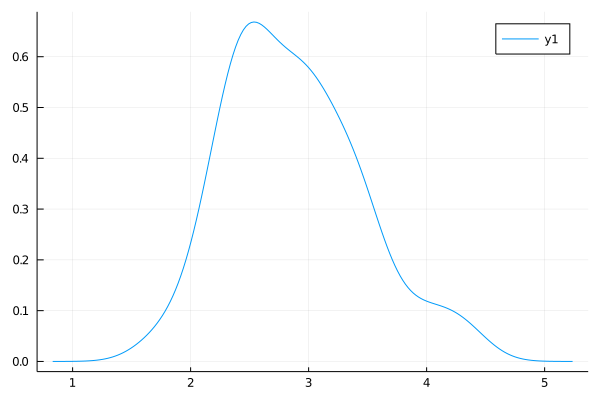

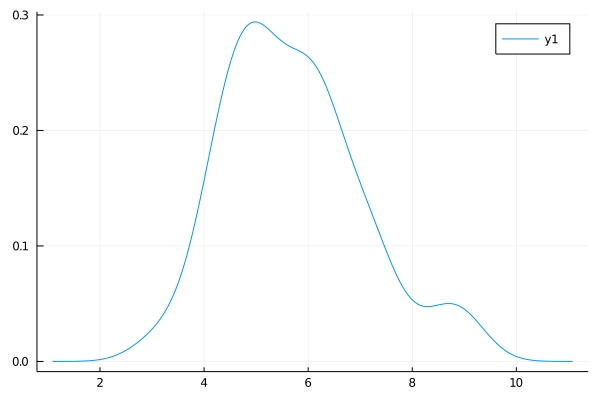

uad_alpha: mean = 2.8738504589908858 var = 0.3280083120507606
uad_delta: mean = 5.719991625186385 var = 1.751017079828741


In [917]:
# Plots of empirical density for each parameter
uad_alpha = density(uasim_pars[:,1])
display(uad_alpha)
uad_delta = density(uasim_pars[:,2])
display(uad_delta)
println("uad_alpha: mean = ", mean(uasim_pars[:,1]), " var = ", var(uasim_pars[:,1]))
println("uad_delta: mean = ", mean(uasim_pars[:,2]), " var = ", var(uasim_pars[:,2]))

In [5]:
# Load data
df = DataFrame()
df = CSV.read("psetTwo.csv", DataFrame)

# Mileage
mileage = df.milage
N = length(mileage)

# Find replacement periods
d_rep = [0; (mileage[2:N] - mileage[1:N-1]) .< 0]

5000-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1

In [462]:
# Discretize the domain (equispacing)
# function disc_domain(data, K)
#     println("equispace used")
#     M = maximum(data)
#     m = minimum(data)
#     return LinRange(m,M,K)
# end

# Discretize domain (equal mass in each bin)
function disc_domain(data, K)
    
    println("equimass used")
    
    # Sort data
    data_sorted = sort(data)
    
    # Initialize
    disc = zeros(K)
    
    # Chunk up so each bin has same number of entries
    for k in 1:K
        disc[k] = data_sorted[Int(floor(k*N/K))]
    end
    
    return disc
end

# Map value to its chunk
function to_chunk(vs, chunks)
    
    # Initialize
    its = zeros(length(vs))
    
    # Find chunk for each v
    for j in 1:length(vs)
        it = 1
        
        # Continue until value larger than lower end of chunk
        while vs[j] > chunks[it] && it < length(chunks)
            it += 1
        end
        its[j] = it
    end
    return Int64.(its)
end

# Create transition matrices
function trans_mats(x, d, K)
    
    # Get discretized domain
    disc = disc_domain(x, K)
    
    # For replacement
#     rep = zeros(K,K)
    
    # For no replacement
    no_rep = zeros(K,K)
    
    # Get chunks
    chunk_map = to_chunk(x, disc)
    
    # Fix this for single matrix
#     for i in 2:length(m)
#         if d[i] > 0
#             rep[chunk_map[i-1], chunk_map[i]] += 1
#         else
#             no_rep[chunk_map[i-1], chunk_map[i]] += 1
#         end
#     end
    
    # Add mass in each transition
    for i in 2:length(x)
        no_rep[chunk_map[i-1], chunk_map[i]] += 1
    end
    
    # If no entries in row, assume full mass on diag?
    for k in 1:K
#         if sum(rep[k,:]) == 0
#             rep[k,1] = 1
#         end
        
        if sum(no_rep[k,:]) == 0
            no_rep[k,k] = 1
        end
        
    end
    
    # Normalize
#     rep = rep.*(1 ./max.(sum(rep,dims=2), 1.0))
    no_rep = no_rep.*(1 ./sum(no_rep,dims=2))
    
    return no_rep #, rep
end

# Utility (shock not included)
function u(x, d, theta)
    if d == 0
        return -theta[1].*x - theta[2].*(x./100).^2
    else
        return -theta[3].*ones(length(x))
    end
end

# Jacobian of u wrt theta
function uj(x, d, theta)
    if d == 0
        return hcat(-x, -(x./100).^2, zeros(length(x)))
    else
        return hcat(zeros(length(x)), zeros(length(x)), -ones(length(x)))
    end
end


# For fixed point of EV
function Gamma(EV, P, X, beta, theta)
#     println("in Gamma P: ", size(P))
#     println("exp term: ", size(exp.(u(X,0,theta) .+ beta.*EV)))
#     println("other: ", size(log.(exp.(u(X,0,theta) .+ beta.*EV) .+ exp.(u(X,1,theta) .+ beta.*EV[1]))))
    return P*log.(exp.(u(X,0,theta) .+ beta.*EV) .+ exp.(u(X,1,theta) .+ beta.*EV[1]))
end

# Conditional choice probs
# (sum to 1 when considering exactly exhaustive choices)
# Default to just using X, EV
function ch_probs(EV, X, beta, theta, x_inds = [i for i in 1:length(X)])
    return exp.(u(X[x_inds],0,theta) .+ beta.*EV[x_inds] .- maximum(u(X[x_inds],0,theta) .+ beta.*EV[x_inds]))./(exp.(u(X[x_inds],0,theta) .+ beta.*EV[x_inds] .- maximum(u(X[x_inds],0,theta) .+ beta.*EV[x_inds])) .+ exp.(u(X[x_inds],1,theta) .+ beta.*EV[1] .- maximum(u(X[x_inds],0,theta) .+ beta.*EV[x_inds])))
end

# Jacobian of Gamma wrt EV (K x K)
function Gamma_jac_EV(EV, P, X, beta, theta)
#     pr(theta, beta, P, X)
#     return P*(diagm(pr(theta, beta, P, X)) .* beta .+ (1 .- pr(theta, beta, P, X)) .* beta .* [i == 1 for j in 1:length(X), i in 1:length(X)])
    return P*(diagm(ch_probs(EV, X, beta, theta)) .* beta .+ (1 .- ch_probs(EV, X, beta, theta)) .* beta .* [i == 1 for j in 1:length(EV), i in 1:length(EV)])
end

# Jacobian of Gamma wrt theta (K x 3)
function Gamma_jac_theta(EV, P, X, beta, theta)
    return P*((exp.(u(X,0,theta) .+ beta.*EV .- maximum(u(X,0,theta) .+ beta.*EV))  .* uj(X,0,theta) .+ exp.(u(X,1,theta) .+ beta.*EV[1] .- maximum(u(X,0,theta) .+ beta.*EV)) .* uj(X,1,theta))./(exp.(u(X,0,theta) .+ beta.*EV .- maximum(u(X,0,theta) .+ beta.*EV)) .+ exp.(u(X,1,theta) .+ beta.*EV[1] .- maximum(u(X,0,theta) .+ beta.*EV))))
end

# Jacobian of Gamma wrt theta (K x 3) (no overflow protection)
# function Gamma_jac_theta(EV, P, X, beta, theta)
#     return P*(exp.(u(X,0,theta) .+ beta.*EV)  .* uj(X,0,theta) .+ exp.(u(X,1,theta) .+ beta.*EV[1]) .* uj(X,1,theta))./(exp.(u(X,0,theta) .+ beta.*EV) .+ exp.(u(X,1,theta) .+ beta.*EV[1]))
# end

# Contraction mapping to solve EV
function contract_EV(EV, P, X, beta, theta, maxiter = 1000, tol = 1e-5)
    
    # Initialize
    it = 1
    diff = Inf
    EVnew = zeros(length(EV))
    
    while it < maxiter && diff > tol
        
        # Find new
        EVnew = Gamma(EV, P, X, beta, theta)
        
        # Find diff
        diff = maximum(abs.(EVnew - EV))
        
        # Update
        it += 1
        EV = EVnew
    end
    
    # Status updates
#     println("Contraction done")
#     println("    it: ", it)
#     println("    diff: ", diff)
#     println("    EV: ", EV)
    
    return EV
end

# Newton-Kantorovich to solve EV
function nk_EV(EV, P, X, beta, theta, maxiter = 1000, tol = 1e-14)
    
    # Initialize
    it = 1
    diff = Inf
    EVnew = zeros(length(EV))
    
    while it < maxiter && diff > tol
        
        # Get new
        EVnew = EV - (I - Gamma_jac_EV(EV, P, X, beta, theta)) \ (EV - Gamma(EV, P, X, beta, theta))
        
        # Get diff
        diff = maximum(abs.(EVnew - EV))
        
        # Update
        it += 1
        EV = EVnew
    end
    
    # Status updates
#     println("Newton-Kantorovich done")
#     println("    it: ", it)
#     println("    diff: ", diff)
#     println("    EV: ", EV)
    
    return EV
end

# Combine contraction and Newton-Kantorovich
function poly_algo(P, X, beta, theta,
        maxiter_c = 1000, tol_c = 1e-5,
        maxiter_nk = 1000, tol_nk = 1e-16
    )
    
    # Initialize
    EV = zeros(length(X))
    
    # Contract
    EV = contract_EV(EV, P, X, beta, theta, maxiter_c, tol_c)
    
    # NK
    EV = nk_EV(EV, P, X, beta, theta, maxiter_nk, tol_nk)
    
    return EV
end

# Log-likelihood
function log_lik(theta, beta, d, X, x_inds)
#     return d'*log.(1 .- pr(theta, beta, P, X, x_inds)) .+ (1 .- d')*log.(pr(theta, beta, P, X, x_inds))
    return (d'*log.(1 .- ch_probs(poly_algo(P, X, beta, theta), X, beta, theta, x_inds)) .+ (1 .- d')*log.(ch_probs(poly_algo(P, X, beta, theta), X, beta, theta, x_inds)))[1]
end

# Log-likelihood (EV known)
# function log_lik_simple(theta, beta, d, X, EV, x_inds)
#     return return d'*log.(1 .- ch_probs(EV, X, beta, theta, x_inds)) .+ (1 .- d')*log.(ch_probs(EV, X, beta, theta, x_inds))
# end

# Expression inside exp in jacobian of probs
# Note: no - max(V) stabilization here
function inside_exp(theta, beta, X, x_inds)
    return u(X[x_inds],1,theta) .+ beta.* poly_algo(P, X, beta, theta)[1] .- u(X[x_inds],0,theta) .- beta.*poly_algo(P, X, beta, theta)[x_inds]
end

# Jacobian of expression inside exp
function inside_exp_jac(theta, beta, X, x_inds)
    return uj(X[x_inds], 1, theta) .+ beta .*EV_jac(poly_algo(P, X, beta, theta), P, X, beta, theta)[1,:]' .- uj(X[x_inds], 0, theta) .- beta .* EV_jac(poly_algo(P, X, beta, theta), P, X, beta, theta)[x_inds,:]
end

# choice probs (used for AD testing)
function pr(theta, beta, P, X, x_inds = [i for i in 1:length(X)])
#     println("AAA")
    return exp(-maximum(inside_exp(theta, beta, X, x_inds))) ./ (exp(-maximum(inside_exp(theta, beta, X, x_inds)))  .+ exp.(inside_exp(theta, beta, X, x_inds) .- maximum(inside_exp(theta, beta, X, x_inds))))
end

# Take advantage of EV and EVjac known
function simple_inside_exp(theta, beta, X, EV, EVjac, x_inds)
    return uj(X[x_inds], 1, theta) .+ beta .* EVjac[1,:]' .- uj(X[x_inds], 0, theta) .- beta .* EVjac[x_inds, :]
end

# Take advantage of EV and EVjac known
function simple_inside_exp_jac(theta, beta, X, EV, EVjac, x_inds)
    return uj(X[x_inds], 1, theta) .+ beta .*EVjac[1,:]' .- uj(X[x_inds], 0, theta) .- beta .* EVjac[x_inds,:]
end

# Jacobian of choice probs wrt theta (EV and EVjac known)
function pr_jac_simple(theta, beta, X, EV, EVjac, x_inds = [i for i in 1:length(X)])
    return -exp.(simple_inside_exp(theta, beta, X, EV, EVjac, x_inds)) ./ ((1 .+ exp.(simple_inside_exp(theta, beta, X, EV, EVjac, x_inds))).^2) .* simple_inside_exp_jac(theta, beta, X, EV, EVjac, x_inds)
end

function pr_jac(theta, beta, X, x_inds = [i for i in 1:length(X)])
    return -exp.(inside_exp(theta, beta, X, x_inds)) ./ ((1 .+ exp.(inside_exp(theta, beta, X, x_inds))).^2) .* inside_exp_jac(theta, beta, X, x_inds)
end

# Jacobian of EV wrt theta
function EV_jac(EV, P, X, beta, theta)
    return (I - Gamma_jac_EV(EV, P, X, beta, theta)) \ Gamma_jac_theta(EV, P, X, beta, theta)
end

# Jacobian of log likelihood (wrt theta) (EV, EVjac known)
function log_lik_jac_simple(theta, beta, d, X, EV, EVjac, P, x_inds)
    return (-d.*(1 ./(1 .- ch_probs(EV, X, beta, theta, x_inds))) .+ (1 .- d).*(1 ./ch_probs(EV, X, beta, theta, x_inds)))' * pr_jac(theta, beta, X, EV, EVjac, x_inds)
end

# Jacobian of log likelihood (wrt theta)
function log_lik_jac(theta, beta, d, X, P, x_inds)
    return ((-d.*(1 ./(1 .- pr(theta, beta, P, X, x_inds))) .+ (1 .- d).*(1 ./pr(theta, beta, P, X, x_inds)))' * pr_jac(theta, beta, X, x_inds))[1,:]
end

# Jacobian of log likelihood (wrt theta) for optimizing
# function log_lik_jac_op(storage, z)
#     storage = log_lik_jac(z, beta, d, X, P, x_inds)
# end

function solve_theta(beta, d, x, K, theta_init = [0.01, 0.01, 0.01])
    P = trans_mats(x, d, K)
#     println("P: ", P)
    X = disc_domain(x, K)
#     println("X: ", X)
    x_inds = to_chunk(x,X)
#     println("x_inds: ", x_inds)
    
    ll(z) = -log_lik(z, beta, d, X, x_inds)
    
#     llj(z) =  -log_lik_jac(z, beta, d, X, P, x_inds)
    
    function llj!(storage, z)
        storage .= -log_lik_jac(z, beta, d, X, P, x_inds)
    end
    
#     return optimize(ll, theta_init, NelderMead())
#     return optimize(ll, theta_init, LBFGS(); autodiff = :forward)
    return optimize(ll, llj!, theta_init, BFGS()) #, inplace = false)
end


solve_theta (generic function with 2 methods)

In [476]:
# Random.seed!(1234)
K = 5
P = trans_mats(mileage, d_rep, K)
X = disc_domain(mileage, K)
D = rand(K) .> 1/2
beta = 0.999
theta = [0.01,0.02,0.03]

x = mileage
x_inds = to_chunk(x, X)
d = d_rep

EV = zeros(K)

# contract_EV(EV, P, X, beta, theta)
# nk_EV(EV, P, X, beta, theta)

EV = poly_algo(P, X, beta, theta)
EVjac = EV_jac(EV, P, X, beta, theta)
# EV[x_ind]

# println("ch: ", ch_probs(EV, X, beta, theta))

# println("pr: ", pr(theta, beta, P, X))
# println("ch - pr: ", ch_probs(EV, X, beta, theta) - pr(theta, beta, P, X))

# d = [1.0, 0.0, 1.0, 0.0, 0.0]
# x = [X[1], X[2], X[1], X[2], X[3]]

# uj(X, 0, theta)
# uj(X, 1, theta)
# Gamma_jac_theta(EV, P, X, beta, theta)
# EV_jac(EV, P, X, beta, theta)

# log_lik(theta, beta, d, X, EV, x_inds)




# Check Jacobians against AD here

# u
# println("u jac: ", uj(x, 0, theta))
u_forAD0(z) = u(x, 0, z)
ForwardDiff.jacobian(u_forAD0, theta) - uj(x, 0, theta)

# println("u jac: ", uj(x, 0, theta))
u_forAD1(z) = u(x, 1, z)
ForwardDiff.jacobian(u_forAD1, theta) - uj(x, 1, theta)

# Gamma EV
# println("Gamma jac EV: ", Gamma_jac_EV(EV, P, X, beta, theta))
GEV_forAD(z) = Gamma(z, P, X, beta, theta)
ForwardDiff.jacobian(GEV_forAD, EV) - Gamma_jac_EV(EV, P, X, beta, theta)

# Gamma theta
# println("Gamma jac theta: ", Gamma_jac_theta(EV, P, X, beta, theta))
# Gtheta_forAD(z) = Gamma(EV, P, X, beta, z)
# ForwardDiff.jacobian(Gtheta_forAD, theta) - Gamma_jac_theta(EV, P, X, beta, theta)

# EV - seems to be within error margin? (2e-11)
# Actually probably pretty good since this is the jacobian of an FP algo
# println("EV jac theta: ", EV_jac(EV, P, X, beta, theta))
EV_forAD(z) = poly_algo(P, X, beta, z)
ForwardDiff.jacobian(EV_forAD, theta) - EVjac #EV_jac(EV, P, X, beta, theta)


# inside_exp_jac(theta, beta, X, x_inds)


# inside_exp
# println("ie jac: ", inside_exp_jac(theta, beta, X, x_inds))
# ie_forAD(z) = inside_exp(z, beta, X, x_inds)
# ForwardDiff.jacobian(ie_forAD, theta) - inside_exp_jac(theta, beta, X, x_inds)

# p
# -> ch_probs does not take into account how theta affects EV
# println("pr jac: ", pr_jac(theta, beta, X))
# pr_forAD(z) = pr(z, beta, P, X)
# ForwardDiff.jacobian(pr_forAD, theta) - pr_jac(theta, beta, X)

# log lik (BROKEN BECAUSE OF PR BROKEN)
# println("log lik jac: ", size(log_lik_jac(theta, beta, d, X, P, x_inds)))
# ll_forAD(z) = log_lik(z, beta, d, X, x_inds)
# ForwardDiff.gradient(ll_forAD, theta) - log_lik_jac(theta, beta, d, X, P, x_inds)

# log_lik(theta, beta, d, X, x_inds)

# NEED TO CHECK FOR OVERFLOW
# Solve for theta
theta_init = [0.001, 0.01, 0.01]
soln = solve_theta(beta, d, x, K, theta_init)

equimass used
equimass used
equimass used
equimass used


 * Status: success

 * Candidate solution
    Final objective value:     3.180850e+03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.73e-18 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.73e-16 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.42e+05 ≰ 1.0e-08

 * Work counters
    Seconds run:   13  (vs limit Inf)
    Iterations:    4
    f(x) calls:    320
    ∇f(x) calls:   320


In [477]:
soln.minimizer

3-element Array{Float64,1}:
 -0.0009379236102099465
  0.009966453941326345
  0.0100117408828595